# New evaluation test set playground

this file will be used to test different finetuned models. everytime it is used, please save the results in a different copy and leave this file as clean as possible 

Changes:


In [16]:
import os
import numpy as np
import json
import pandas as pd
from birdnetlib.analyzer import Analyzer
from birdnetlib.batch import DirectoryAnalyzer
import matplotlib.pyplot as plt 
import copy         # deepcopy
import seaborn as sns

In [237]:
MODEL_NAME = "wabad_on_minor"
DATASET_NAME = "NEW_DATASET"
DATASET_PATH = f"E:/Giacomo/Tovanella/{DATASET_NAME}"

## test the model and extract predictions

In [238]:
complete_pred_segments = {}
def on_analyze_complete(recording):
    audio_name = recording.path.split('\\')[-1]
    if len(audio_name.split("_")) == 3:
        date, number, segm_id = audio_name.split('_')    # <20200215>_<090000>_<88.wav>
        segm_id = segm_id.split('.')[0]               # <88>.<wav>
    audio_name = "_".join([date, number]) + ".WAV"      # 20190603_030000_196.WAV
    if audio_name not in complete_pred_segments:
        complete_pred_segments[audio_name] = {}
    if segm_id not in complete_pred_segments[audio_name]:
        complete_pred_segments[audio_name][segm_id] = {}
    complete_pred_segments[audio_name][segm_id] = { 
        detection["label"]: detection["confidence"] for detection in recording.detections 
    }
    print("Analyzing ", recording.path)

def on_error(recording, error):
    print("An exception occurred: {}".format(error))
    print(recording.path)

In [239]:
with open(f"utils/{DATASET_NAME}/true_segments.json") as f:
    all_segments = json.load(f)

In [240]:
with open("utils/category_info.json") as f:
    category_info = json.load(f)

species_list = list(category_info.keys())

## Thresholds

In [241]:
# save best_threshold_by_species
best_threshold_by_species = {}
if os.path.exists(f"classifiers/official/{MODEL_NAME}/best_threshold_by_species.json"):
    with open(f"classifiers/official/{MODEL_NAME}/best_threshold_by_species.json") as f:
        best_threshold_by_species = json.load(f)

# Testing 

In [242]:
model_path = f"classifiers/official/{MODEL_NAME}/CustomClassifier.tflite"
labels_path = f"classifiers/official/{MODEL_NAME}/CustomClassifier_Labels.txt"
valid_path = "E:/Giacomo/Tovanella/DATASET/validation"
min_conf = 0.1

analyzer = Analyzer(
    classifier_labels_path=labels_path, 
    classifier_model_path=model_path,
)      

load_custom_models
Custom model loaded.
loading custom classifier labels
Labels loaded.
load model False
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.


In [243]:
complete_pred_segments = {}
test_path = f"{DATASET_PATH}/test"
for folder in os.listdir(test_path):
    directory = os.path.join(test_path, folder)

    print("Starting Watcher: ", folder)
    batch = DirectoryAnalyzer(
        directory,
        analyzers=[analyzer],
        min_conf=min_conf,
    )

    batch.on_analyze_complete = on_analyze_complete
    batch.on_error = on_error
    batch.process()

Starting Watcher:  Certhia familiaris_Eurasian Treecreeper
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190608_070000_63.wav
Analyzing  E:\Giacomo\Tovanella\NEW_DATASET\test\Certhia familiaris_Eurasian Treecreeper\20190608_070000_63.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190608_070000_82.wav
Analyzing  E:\Giacomo\Tovanella\NEW_DATASET\test\Certhia familiaris_Eurasian Treecreeper\20190608_070000_82.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190608_070000_83.wav
Analyzing  E:\Giacomo\Tovanella\NEW_DATASET\test\Certhia familiaris_Eurasian Treecreeper\20190608_070000_83.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190608_070000_88.wav
Analyzing  E:\Giacomo\Tovanella\NEW_DATASET\test\Certhia familiaris_Eurasian Treecreeper\20190608_070000_88.wav
read_audio_data
read_audio_data: complete, read  1 chunks.
analyze_recording 20190608_070000_

In [244]:
# SAVE
test_complete_pred_segments = copy.deepcopy(complete_pred_segments)
with open(f"classifiers/official/{MODEL_NAME}/test_complete_pred_segments_1.json", "w") as f:
    json.dump(test_complete_pred_segments, f)

In [245]:
# LOAD, ATTENZIONE AL _1
# with open(f"classifiers/official/{model_name}/test_complete_pred_segments_1.json") as f:
#     complete_pred_segments = json.load(f)

In [246]:
test_pred_segments = copy.deepcopy(test_complete_pred_segments)
for audio in test_complete_pred_segments:
    for segm_id in test_complete_pred_segments[audio]:
        species_to_save = []
        for label, conf_score in test_complete_pred_segments[audio][segm_id].items():
            if best_threshold_by_species != {}:
                if conf_score > best_threshold_by_species[label]:     # soglia dinamica
                    species_to_save.append(label)
            else:
                if conf_score > 0.2:     # soglia dinamica
                    species_to_save.append(label)
        test_pred_segments[audio][segm_id] = species_to_save

In [247]:
test_true_segments = {}
for audio in all_segments.keys():
    if audio in test_pred_segments:
        test_true_segments[audio] = {}
        for key, values in all_segments[audio].items():
            if key in test_pred_segments[audio]:
                test_true_segments[audio][key] = [value for value in values if value in species_list]

## get results

In [248]:
from sklearn.preprocessing import MultiLabelBinarizer

species_list = []
# with open(f"classifiers/official/{model_name}/CustomClassifier_Labels.txt") as f:
#     for line in f:  # Iteriamo direttamente sulle righe del file
#         species_list.append(line.strip())  # Rimuovi eventuali spazi bianchi e newline
species_list = os.listdir(test_path)

# species_list.remove("Pecking_")
# species_list.remove("Rain_")
# species_list.remove("Vegetation_")
# species_list.remove("Wind_")
# species_list.remove("Glaucidium passerinum_Eurasian Pygmy-Owl")
# species_list.remove("Turdus merula_Eurasian Blackbird")
# species_list.remove("Muscicapa striata_Spotted Flycatcher")
# species_list.remove("Periparus ater_Coal Tit")
# species_list.remove("Pyrrhula pyrrhula_Eurasian Bullfinch")

mlb = MultiLabelBinarizer()
mlb.fit([list(species_list)])

len(mlb.classes_)

18

### classification report

In [249]:
y_pred = []
y_true = []
for audio in test_pred_segments:
    # sort in increasing order
    sortable_true_segments = { str(key): value for key, value in test_true_segments[audio].items() }
    sortable_pred_segments = { str(key): value for key, value in test_pred_segments[audio].items() }
    sorted_true_segments = dict(sorted(sortable_true_segments.items()))
    sorted_pred_segments = dict(sorted(sortable_pred_segments.items()))
    y_true.append(mlb.transform(sorted_true_segments.values()))     # apply transform on every label of every segment
    y_pred.append(mlb.transform(sorted_pred_segments.values()))     # apply transform on every label of every segment

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Muscicapa striata_Spotted Flycatcher', 'Phylloscopus collybita_Common Chiffchaff'] will be ignored
  warnings.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Muscicapa striata_Spotted Flycatcher', 'Phylloscopus collybita_Common Chiffchaff', 'Turdus viscivorus_Mistle Thrush'] will be ignored
  warnings.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Muscicapa striata_Spotted Flycatcher'] will be ignored
  warnings.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Glaucidium passerinum_Eurasian Pygmy-Owl', 'Phylloscopus collybita_Common Chiffchaff'] wi

In [250]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
with open(f"classifiers/official/{MODEL_NAME}/classification_report_1.json", "w") as f:
    json.dump(report, f)

report_df = pd.DataFrame(report).T
report_df

,precision,recall,f1-score,support
Certhia familiaris_Eurasian Treecreeper,1.000000,0.043478,0.083333,23.0
Dendrocopos major_Great Spotted Woodpecker,0.916667,1.000000,0.956522,11.0
Dryocopus martius_Black Woodpecker,1.000000,0.100000,0.181818,10.0
Erithacus rubecula_European Robin,0.281250,0.375000,0.321429,48.0
Fringilla coelebs_Common Chaffinch,0.905709,0.809745,0.855043,1293.0
Lophophanes cristatus_Crested Tit,0.333333,0.052632,0.090909,19.0
Loxia curvirostra_Common Crossbill,0.392157,0.833333,0.533333,24.0
Pecking_,0.142857,0.636364,0.233333,11.0
Periparus ater_Coal Tit,0.848485,0.437500,0.577320,64.0
Rain_,0.727273,0.421053,0.533333,19.0


In [251]:
pred_array = []
for key in test_pred_segments.keys():
    for value in test_pred_segments[key].values():
        pred_array.extend(set(v for v in value if v in species_list))

In [252]:
true_array = []
for key in test_true_segments.keys():
    for value in test_true_segments[key].values():
        true_array.extend(set(v for v in value if v in species_list))

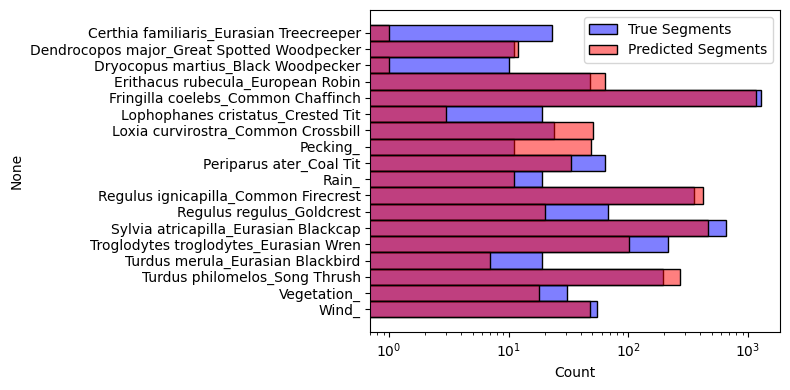

In [253]:
# Converti gli array in Series di pandas per contare le occorrenze
true_series = pd.Series(true_array)
pred_series = pd.Series(pred_array)

# Conta le occorrenze e crea DataFrame
true_counts = true_series.value_counts().sort_index()
pred_counts = pred_series.value_counts().sort_index()

# Unisci i due DataFrame per avere tutte le categorie
all_categories = pd.concat([true_counts, pred_counts], axis=1, sort=True).fillna(0)
all_categories.columns = ['True Segments', 'Predicted Segments']

# Crea il grafico orizzontale
plt.figure(figsize=(8, 4))  # Aumenta la larghezza per le etichette
sns.histplot(data=all_categories, y=all_categories.index, weights='True Segments', alpha=0.5, color='blue', label='True Segments', discrete=True, orientation='horizontal')
sns.histplot(data=all_categories, y=all_categories.index, weights='Predicted Segments', alpha=0.5, color='red', label='Predicted Segments', discrete=True, orientation='horizontal')

plt.xscale('log')  # Scala logaritmica sull'asse x
plt.legend()
plt.tight_layout()
plt.show()

### auc roc

In [254]:
y_pred_conf = []

for audio in test_pred_segments:
    scores_pred = []
    for segm, predictions in complete_pred_segments[audio].items():
        segm_conf_score = np.zeros(len(mlb.classes_))  # Vettore inizializzato a 0 per tutte le classi

        for pred, conf in predictions.items():
            binary_vector = mlb.transform([[pred]])[0]  # Convertiamo in binario (shape: (n_classes,))
            segm_conf_score += binary_vector * conf  # Moltiplichiamo per il confidence score

        scores_pred.append(segm_conf_score)  # Ogni segmento ora ha un array della stessa lunghezza di n_classes
    
    y_pred_conf.append(np.array(scores_pred))  # Lista di array uniformi

# Convertiamo in un array 2D
y_pred_conf = np.vstack(y_pred_conf)

c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Muscicapa striata_Spotted Flycatcher'] will be ignored
  warnings.warn(


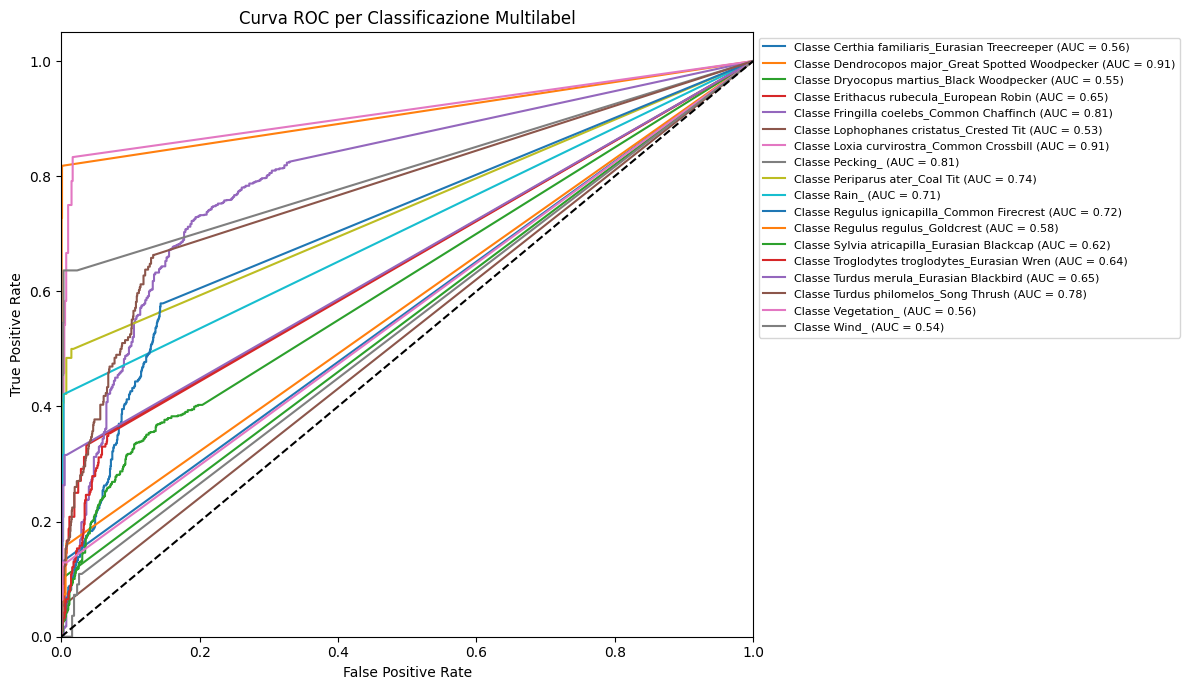

In [255]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(12, 7))  # Aumenta la dimensione
n_classes = len(mlb.classes_)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_conf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Classe {mlb.classes_[i]} (AUC = {roc_auc:.2f})')

# Linea di riferimento
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC per Classificazione Multilabel')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.show()

In [256]:
roc_data = {}

n_classes = len(mlb.classes_)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_conf[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Salviamo i dati in un dizionario
    roc_data[mlb.classes_[i]] = {
        "fpr": fpr.tolist(),  # Converti in lista per compatibilità JSON
        "tpr": tpr.tolist(),
        "auc": roc_auc
    }
    
with open(f"classifiers/official/{MODEL_NAME}/roc_auc_1.json", "w") as f:
    json.dump(roc_data, f)